In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

Data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [6]:
labels_pd = pd.read_csv("/content/labels.csv")
counts_pd = pd.read_csv("/content/processed_counts.csv")
labels_pd.head()

,index,bulk_labels
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte
1,AAATTCGATGCACA-1,Dendritic
2,AACACGTGGTCTTT-1,CD56+ NK
3,AAGTGCACGTGCTA-1,CD4+/CD25 T Reg
4,ACACGAACGGAGTG-1,Dendritic


In [7]:
counts_pd.head()

,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


In [8]:
# remove the barcode from the genes
counts_numeric = counts_pd.drop(columns=counts_pd.columns[0])
counts_numeric.head()

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


In [9]:
from sklearn.model_selection import ShuffleSplit

In [10]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html

# Set up ShuffleSplit
shufflesplit = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split and Shuffle Data
for train_idx, test_idx in shufflesplit.split(counts_numeric):

  X_train = counts_numeric.iloc[train_idx]
  X_test = counts_numeric.iloc[test_idx]

  y_train = labels_pd.iloc[train_idx]
  y_test = labels_pd.iloc[test_idx]

In [11]:
import torch
import torch.nn as nn
import torchvision
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128 # 765 --> 128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=32
        ) # Bc out_features = 32, we have a latent representation of 32 features

        self.decoder_hidden_layer = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"] #. 128 --> 765
        )

    def forward(self, features, return_encoding=False):
        #when return encoding is True,
        #forward will return both the reconstructed data and the latent encoding
        encoded = self.encoder_hidden_layer(features)
        encoded  = torch.relu(encoded)
        encoded  = self.encoder_output_layer(encoded)
        encoded = torch.relu(encoded)
        decoded = self.decoder_hidden_layer(encoded)
        decoded = torch.relu(decoded)
        decoded = self.decoder_output_layer(decoded)
        reconstructed = torch.sigmoid(decoded) #values in MNIST range from 0 to 1, so we should restrict output to [0,1] using sigmoid
        if return_encoding: #see https://stackoverflow.com/questions/68211353/extracting-hidden-representations-from-an-autoencoder-using-pytorch
            return reconstructed, encoded
        return reconstructed

In [13]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(input_shape=765).to(device) # RNA seq counts of the 765 different genes

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [14]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# create dataloaders
train_loader = torch.utils.data.DataLoader(
    X_train_tensor, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    X_test_tensor, batch_size=32, shuffle=False, num_workers=2
)

In [15]:
epochs=25
l1_param = 0.0001 #how strongly to enforce l1 regularization - play around with this

for epoch in range(epochs):
    loss = 0
    total_mse = 0.0
    l1_loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 765).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions and encoded
        outputs, encoded = model(batch_features, return_encoding=True)

        # apply penalty to all non-zero encoded values
        # https://debuggercafe.com/sparse-autoencoders-using-l1-regularization-with-pytorch/
        l1_regularization = l1_param * torch.mean(torch.abs(encoded))
        l1_loss += l1_regularization
        # compute training reconstruction loss + l1_regularization
        mse_loss = criterion(outputs, batch_features)
        train_loss = mse_loss + l1_regularization

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        total_mse += mse_loss.item()

    # compute the epoch training loss
    loss = loss / len(train_loader)
    avg_mse = total_mse / len(train_loader)

    # ====== Evaluate on test set ======
    model.eval()
    test_mse = 0.0

    with torch.no_grad():
        for test_batch in test_loader:
            test_batch = test_batch.view(-1, 765).to(device)
            test_outputs = model(test_batch)
            test_loss = criterion(test_outputs, test_batch)
            test_mse += test_loss.item()

    avg_test_mse = test_mse / len(test_loader)

    # ====== Print Results ======
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    #display l1 loss
    print("loss from l1:", (l1_loss/len(train_loader)).item())
    # display MSE loss
    print("MSE Loss only:", avg_mse)
    print(f"  ➤ Test MSE:                    {avg_test_mse:.6f}")


epoch : 1/25, loss = 1.242405
loss from l1: 1.2029597201035358e-05
MSE Loss only: 1.2423930168151855
  ➤ Test MSE:                    1.267439
epoch : 2/25, loss = 1.211841
loss from l1: 2.398469405306969e-05
MSE Loss only: 1.211816954612732
  ➤ Test MSE:                    1.225096
epoch : 3/25, loss = 1.145795
loss from l1: 4.917383921565488e-05
MSE Loss only: 1.145745849609375
  ➤ Test MSE:                    1.137539
epoch : 4/25, loss = 1.052853
loss from l1: 9.340266115032136e-05
MSE Loss only: 1.0527596473693848
  ➤ Test MSE:                    1.053560
epoch : 5/25, loss = 0.999603
loss from l1: 0.00015515013365074992
MSE Loss only: 0.9994482517242431
  ➤ Test MSE:                    1.033656
epoch : 6/25, loss = 0.990172
loss from l1: 0.00021065829787403345
MSE Loss only: 0.9899611711502075
  ➤ Test MSE:                    1.032340
epoch : 7/25, loss = 0.995979
loss from l1: 0.00024934133398346603
MSE Loss only: 0.9957295536994935
  ➤ Test MSE:                    1.030819
epoc

Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
y = labels_pd["bulk_labels"].values

In [24]:
pca = PCA(n_components=2)
# TODO: Run PCA on X to get the first 2 principal components
X_pca = pca.fit_transform(counts_numeric)

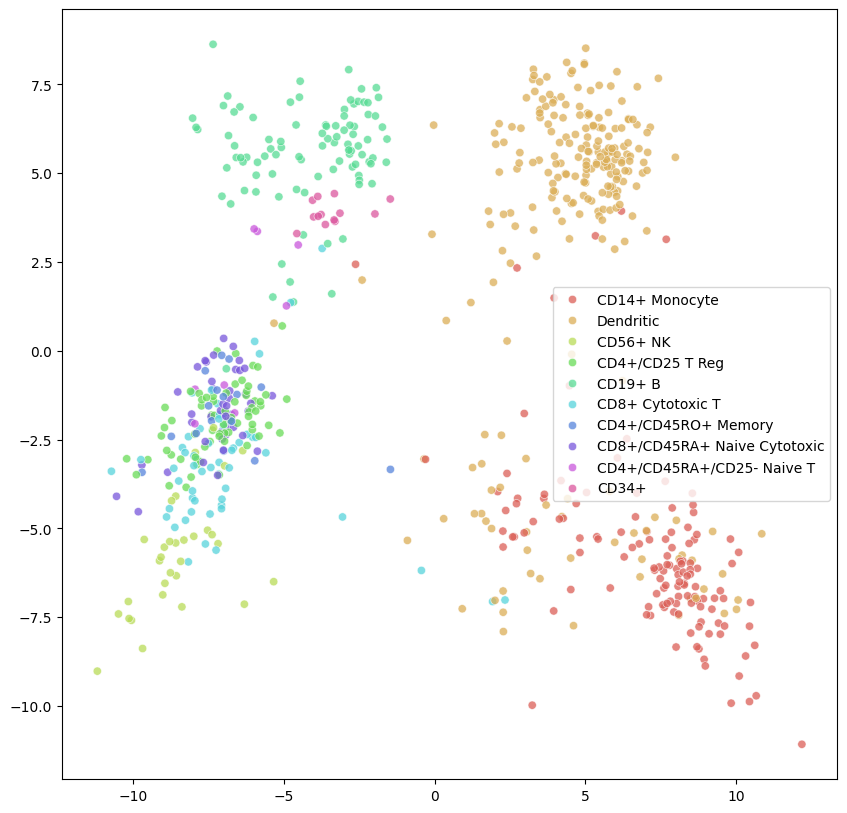

In [25]:
# Visualize X_pca

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

In [28]:
tsne = TSNE(n_components=2, random_state=42)  # Set random_state for reproducibility
X_tsne = tsne.fit_transform(counts_numeric)

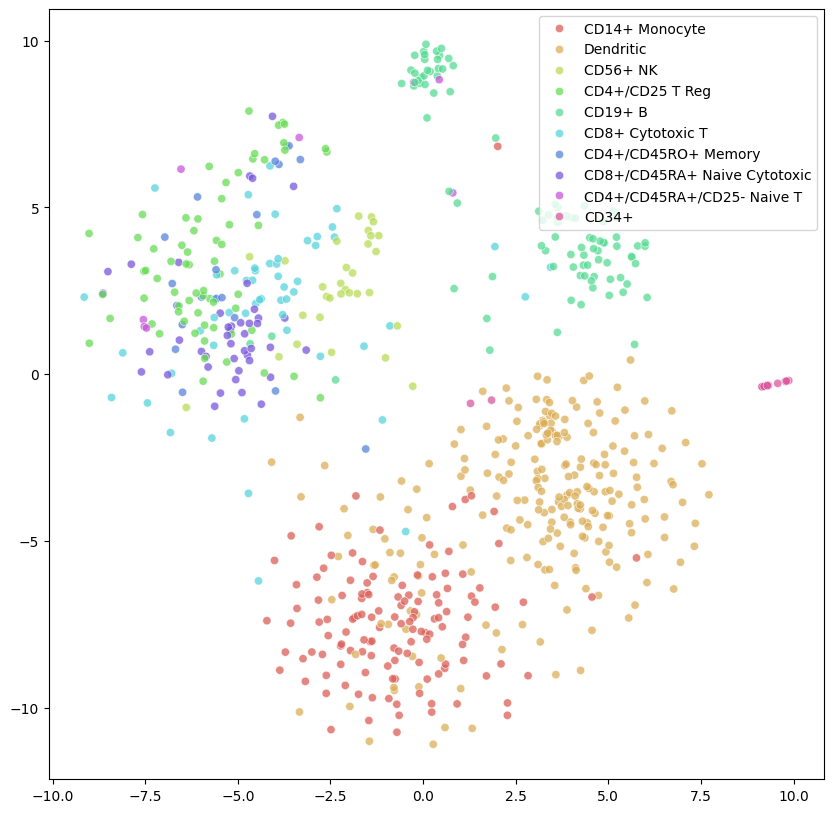

In [29]:
# Visualize X_tsne

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

In [30]:
# obtain latent space representation of data

# Convert data to a PyTorch tensor
input_data = torch.tensor(counts_numeric.values, dtype=torch.float32).to(device)

# Get the latent space representation
with torch.no_grad():  # No need to track gradients here
    _, latent_representation = model(input_data, return_encoding=True)

# Convert the latent representation back to a NumPy array
latent_representation = latent_representation.cpu().numpy()

In [31]:
pca_latent = PCA(n_components=2)
X_pca_latent = pca_latent.fit_transform(latent_representation)

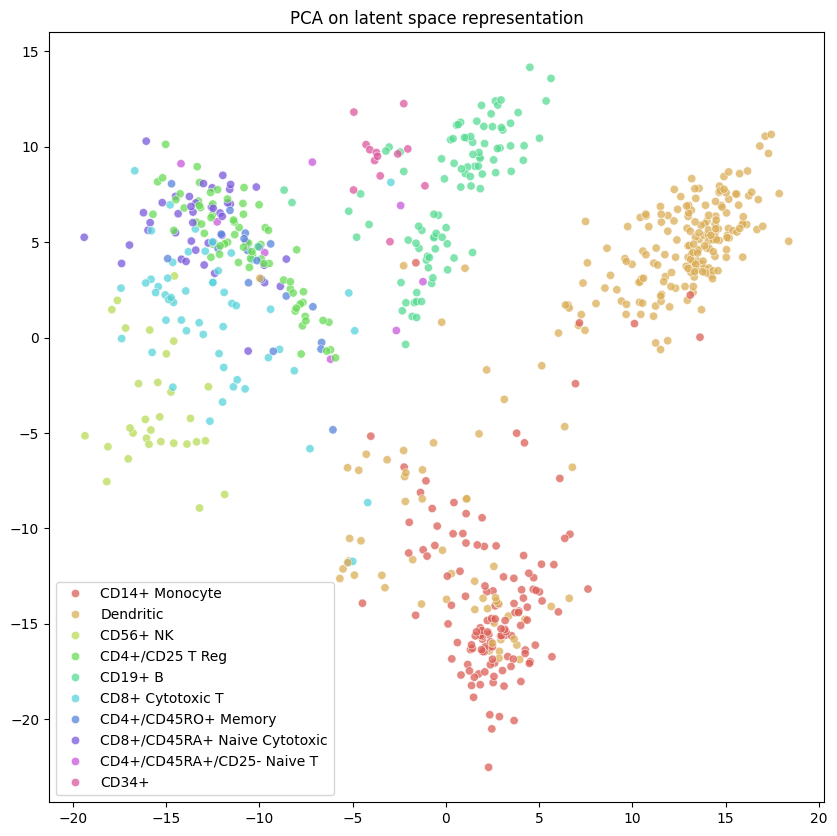

In [32]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=X_pca_latent[:, 0],
    y=X_pca_latent[:, 1],
    hue=y,  # y is the same as before
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75,
)
plt.title("PCA on latent space representation")
plt.show()